# Relax Data Science Challenge
The data is available as two attached CSV files:   
*takehome_user_engagement.csv*  
*takehome_users.csv*

The data has the following two tables:   
1] A user table ( *"takehome_users"* ) with data on 12,000 users who signed up for the product in the last two years.  
2] A usage summary table ( *"takehome_user_engagement"* ) that has a row for each day that a user logged into the product. 

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, **identify which factors predict future user adoption.** 
 
We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings ( the more concise, the better -- no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read and explore datasets

In [2]:
# Read datasets to dataframe
# Convert takehome_users.csv to utf-8 in order to open it properly
df_users = pd.read_csv('takehome_users.csv')
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
df_engage = pd.read_csv('takehome_user_engagement.csv')
df_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
len(df_users)

12000

In [5]:
print('There are {} users signed up for the product.'.format(len(df_users['object_id'].unique())))
print('There are {} users logged into the product.'.format(len(df_engage['user_id'].unique())))

There are 12000 users signed up for the product.
There are 8823 users logged into the product.


In [6]:
# Are there any missing values?
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


8823 users have non-null last_session_creation_time, i.e. they have logged into the product.    
6417 users are invited by other users.

In [7]:
# Fill in empty values of invited_by_user_id 
df_users['invited_by_user_id'] = df_users['invited_by_user_id'].fillna(0)

In [8]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


### Label "adopted user" 

In [9]:
# convert time_stamp to datetime
df_engage['time_stamp'] = pd.to_datetime(df_engage['time_stamp'])

In [10]:
type(df_engage['time_stamp'])

pandas.core.series.Series

In [11]:
from datetime import datetime
df_engage['date'] = df_engage.time_stamp.dt.date

In [12]:
df_engage.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [13]:
df_users['adopted'] = 0

In [14]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [15]:
df_grouped = df_engage.groupby('user_id')

In [16]:
for name, group in df_grouped:
    n = len(group)
    if n >= 3:
        tg = group['date'].drop_duplicates().reset_index(drop=True)
        for i in range(n-2):
            delta = tg[i+2] - tg[i]
            if delta.days < 7:
                #print('user_id=', name)
                df_users.loc[df_users['object_id']==name, 'adopted'] = 1
                break

In [17]:
len(df_users[df_users['adopted']==1])

1602

In [18]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [19]:
count_adopted = len(df_users[df_users['adopted']==1])
print('There are {} adopted users.'.format(count_adopted))
print('{:.2f}% of all users who have signed up for the application are considered \'adopted users\'.'\
          .format(count_adopted/len(df_users)*100))

There are 1602 adopted users.
13.35% of all users who have signed up for the application are considered 'adopted users'.


### Exploratory data analysis

In [20]:
# Check on the higher risk/more defined features
for feature in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    print('{} values:'.format(feature))
    print(df_users[feature].value_counts(), end='\n\n')

creation_source values:
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

opted_in_to_mailing_list values:
0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip values:
0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64



(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

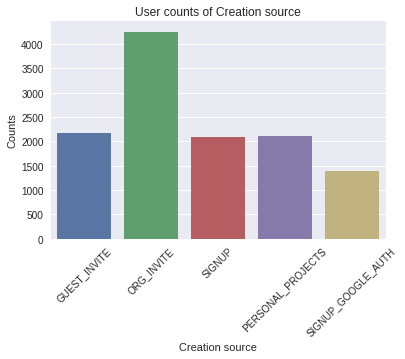

In [21]:
sns.countplot(x='creation_source', data=df_users)
plt.title('User counts of Creation source')
plt.xlabel("Creation source")
plt.ylabel("Counts")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

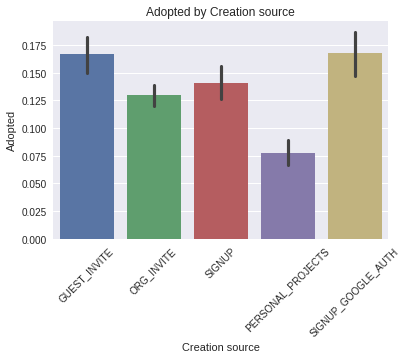

In [22]:
sns.barplot(x='creation_source', y='adopted', data=df_users)
plt.title('Adopted by Creation source')
plt.xlabel("Creation source")
plt.ylabel("Adopted")
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

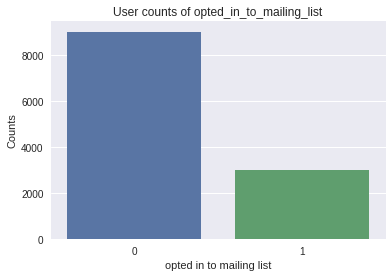

In [23]:
sns.countplot(x='opted_in_to_mailing_list', data=df_users)
plt.title('User counts of opted_in_to_mailing_list')
plt.xlabel("opted in to mailing list")
plt.ylabel("Counts")
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

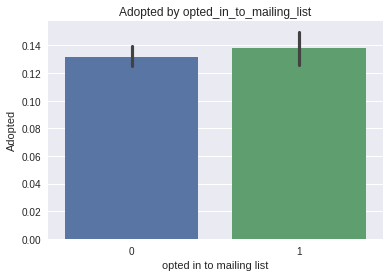

In [24]:
sns.barplot(x='opted_in_to_mailing_list', y='adopted', data=df_users)
plt.title('Adopted by opted_in_to_mailing_list')
plt.xlabel("opted in to mailing list")
plt.ylabel("Adopted")
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

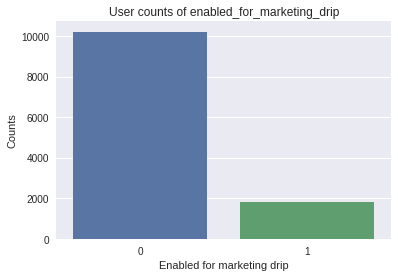

In [25]:
sns.countplot(x='enabled_for_marketing_drip', data=df_users)
plt.title('User counts of enabled_for_marketing_drip')
plt.xlabel("Enabled for marketing drip")
plt.ylabel("Counts")
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

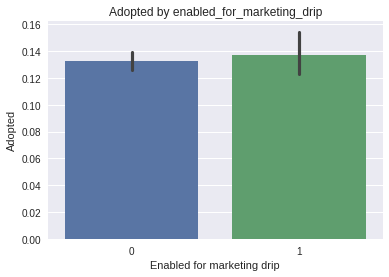

In [26]:
sns.barplot(x='enabled_for_marketing_drip', y='adopted', data=df_users)
plt.title('Adopted by enabled_for_marketing_drip')
plt.xlabel("Enabled for marketing drip")
plt.ylabel("Adopted")
plt.xticks(rotation=0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

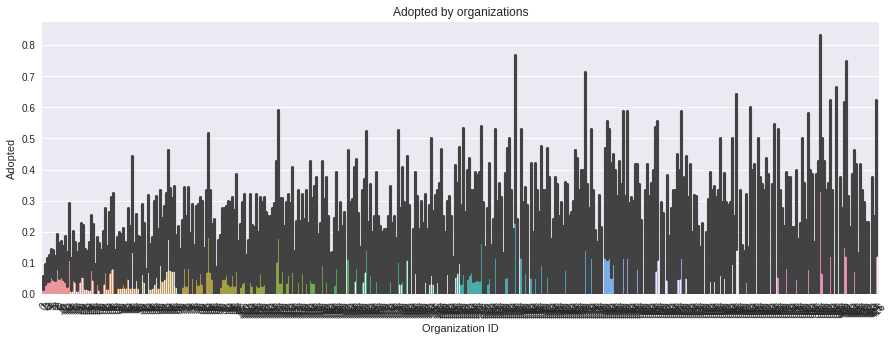

In [28]:
sns.mpl.rc("figure", figsize=(15,5))
sns.barplot(x='org_id', y='adopted', data=df_users)
plt.title('Adopted by organizations')
plt.xlabel("Organization ID")
plt.ylabel("Adopted")
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

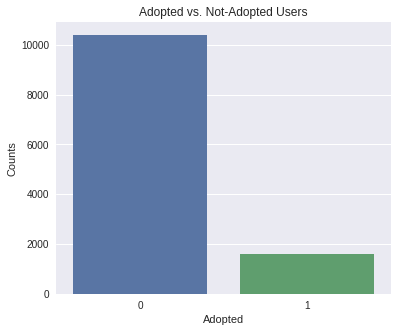

In [29]:
# Distribution of adopted users
sns.mpl.rc("figure", figsize=(6,5))
sns.barplot(x = list(df_users['adopted'].value_counts().index), y = df_users['adopted'].value_counts())
#df_users.groupby('adopted').size().plot(kind='bar')
plt.title('Adopted vs. Not-Adopted Users')
plt.xlabel("Adopted")
plt.ylabel("Counts")
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

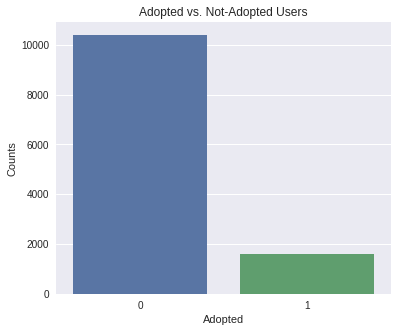

In [30]:
sns.countplot(x='adopted', data=df_users)
plt.title('Adopted vs. Not-Adopted Users')
plt.xlabel("Adopted")
plt.ylabel("Counts")
plt.xticks(rotation=0)

It is an unbalanced dataset. We need to resample the dataset.

### Resampling dataset

#### Resampling methods
In order to tackle imbalanced classification problems which are becoming increasingly present, various resampling methods exist. They aim at balancing data before it is provided as inputs to the training step of the machine learning task. Three main methods are developed hereunder.

__1. Undersampling__

*Undersampling* aims at balancing the dataset distribution by randomly removing some observations from the majority class until the dataset is balanced out. The drawback of this method is that it removes observations from the majority class and therefore may lead to important information loss in the training dataset.

__2. Oversampling __

In contrast to undersampling, *oversampling* aims at randomly replicating instances from the minority class (and thus increasing the minority population) until both classes of the dataset get balanced. Even if this method has the advantage not to lose information, replicating instances in the training dataset may lead to overfitting.

__3. SMOTE (Synthetic Minority Oversampling Technique) __

Instead of replicating instances, this sophisticated method generates artificial new examples from the minority class by operating in "feature space" rather than "data space".  

More precisely, this neighborhood-based technique consists, for each example of the minority class, in computing k of its nearest neighbors and randomly choosing r ≤ k of the neighbors (with replacement). For each of these chosen neighbors, SMOTE will add a random point (i.e. synthetic example) along each of the lines joining the original point and each of the r neighbors. The new dataset is thus composed of the original dataset as well as the synthetic instances.  

Even if this method avoids the problem of overfitting and does not lead to information loss in the training dataset, SMOTE also has substantial limitations. This re-sampling method, relying only on the minority class, can only create artificial examples from the ones that are available. Therefore, SMOTE is restricted to create new examples only in the existing minority examples area and is not able to generate new peripheral regions of minority instances.  

In [31]:
# drop features that are used for identification or are in datetime format and get the dataset for ML
df = df_users[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']]
y = df_users['adopted']

In [32]:
# Creating dummy variables for categorical features
X = pd.get_dummies(df, columns = ['creation_source'], drop_first=False)

In [33]:
from imblearn.over_sampling import SMOTE

# Apply the SMOTE over−s amplin g
sm = SMOTE(ratio='auto', kind='regular')
X1, y1 = sm.fit_sample(X, y)

In [34]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y1)))

Original dataset shape Counter({0: 10398, 1: 1602})
Resampled dataset shape Counter({0: 10398, 1: 10398})


(array([0, 1]), <a list of 2 Text xticklabel objects>)

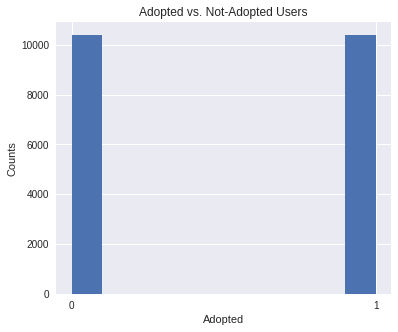

In [35]:
plt.hist(y1)
plt.xticks([0,1])
plt.title('Adopted vs. Not-Adopted Users')
plt.xlabel("Adopted")
plt.ylabel("Counts")
plt.xticks(rotation=0)

### Machine learning

In [36]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

In [37]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16636, 9)
(4160, 9)
(16636,)
(4160,)


In [38]:
from sklearn.ensemble import RandomForestClassifier

# Cross validation
clf = RandomForestClassifier()
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[ 0.82872596  0.84585337  0.84670875  0.83648933  0.85327721]
Average 5-Fold CV Score: 0.8422109226259658


So, using Random Forest Claasifier with default parameters, we can get a model with 84.22% accuracy.

In [39]:
# Train the model on the full training data and test on the test set
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [40]:
# Generate classification report
print(classification_report(y_test, y_pred))
print('Test set accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

             precision    recall  f1-score   support

          0       0.84      0.90      0.87      2089
          1       0.89      0.83      0.86      2071

avg / total       0.86      0.86      0.86      4160

Test set accuracy: 86.15%


In [41]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=range(0,2), columns=range(0,2))

,0,1
0,1872,217
1,359,1712


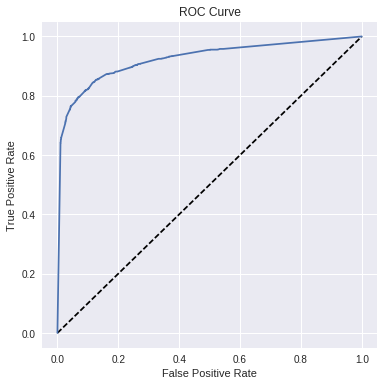

In [42]:
# Compute predicted probabilities
y_pred_prob = rfc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [43]:
# Compute and print AUC score
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.9239


The metrics of final model are:  
1. Test set accuracy: 86.15%
2. AUC: 0.9239

### Feature selection

In [44]:
fi = pd.DataFrame(list(zip(X.columns, rfc.feature_importances_)), columns = ['features', 'Importance'])
fi.sort_values(by='Importance', ascending=False)

,features,Importance
2,org_id,0.344132
3,invited_by_user_id,0.181662
0,opted_in_to_mailing_list,0.140869
6,creation_source_PERSONAL_PROJECTS,0.073818
1,enabled_for_marketing_drip,0.070668
5,creation_source_ORG_INVITE,0.059063
4,creation_source_GUEST_INVITE,0.057061
8,creation_source_SIGNUP_GOOGLE_AUTH,0.038321
7,creation_source_SIGNUP,0.034405


From the importance of features, we find that the most important 3 features are:
1. **org_id**: the organization (group of users) they belong top
2. **invited_by_user_id**: which user invited them to join (if applicable)
3. **opted_in_to_mailing_list**: whether they have opted into receiving marketing emails